# Exponential Smooth to forecast

## Import Library

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finviz.screener import Screener
from typing import List, Dict
from sklearn import logger
from pyfinviz.quote import Quote
from pyfinviz.screener import Screener
from pyfinviz.insider import Insider
import re
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from arch.unitroot import KPSS, ADF
from statsmodels.tsa.forecasting.stl import STLForecast

## Import dataset

In [61]:
# period is three years
end_date = datetime.today().date()

start_date = datetime(2020, 7, 19)
# start_date = end_date - relativedelta(years = 5)

df = yf.download(
  'NKTX',
  start = start_date,
  end = end_date
)


[*********************100%%**********************]  1 of 1 completed


In [62]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-20,36.610001,37.500000,35.599998,36.389999,36.389999,405600
2020-07-21,36.080002,37.500000,32.930000,33.599998,33.599998,137600
2020-07-22,33.779999,34.150002,30.700001,30.850000,30.850000,104300
2020-07-23,31.299999,31.870001,30.129999,30.350000,30.350000,63800
2020-07-24,31.240000,31.240000,28.299999,28.700001,28.700001,92800
...,...,...,...,...,...,...
2024-03-25,10.465000,11.343000,10.160000,10.490000,10.490000,4832700
2024-03-26,10.810000,11.210000,9.300000,9.870000,9.870000,2030500
2024-03-27,9.880000,11.440000,9.820000,11.085000,11.085000,2624500


### Draw open price for NKTX

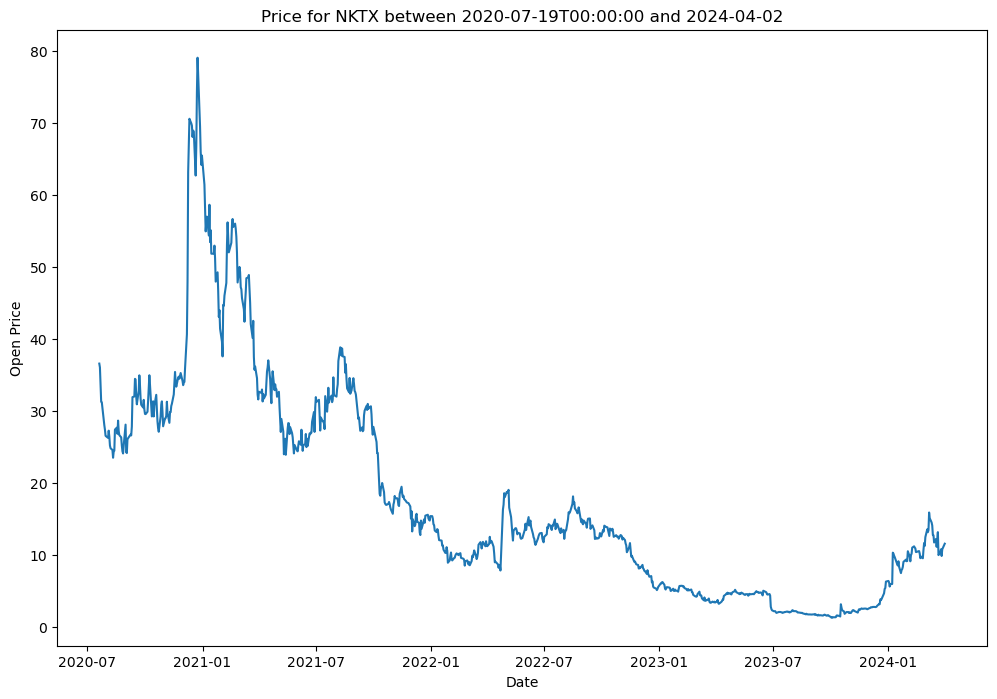

In [63]:
# plot grap of 'NKTX' open price for 5 years
fig, axes = plt.subplots(figsize = (12, 8))
plt.title('Price for NKTX between {} and {}'.format(start_date.isoformat(), end_date.isoformat()))
sns.lineplot(data = df, x = df.index,  y = 'Open')
# sns.lineplot(data = df, x = df.index, y = 'High')
# sns.lineplot(data = df, x = df.index, y = 'Low')
plt.ylabel('Open Price')
plt.show()

### Check autocorrelation 

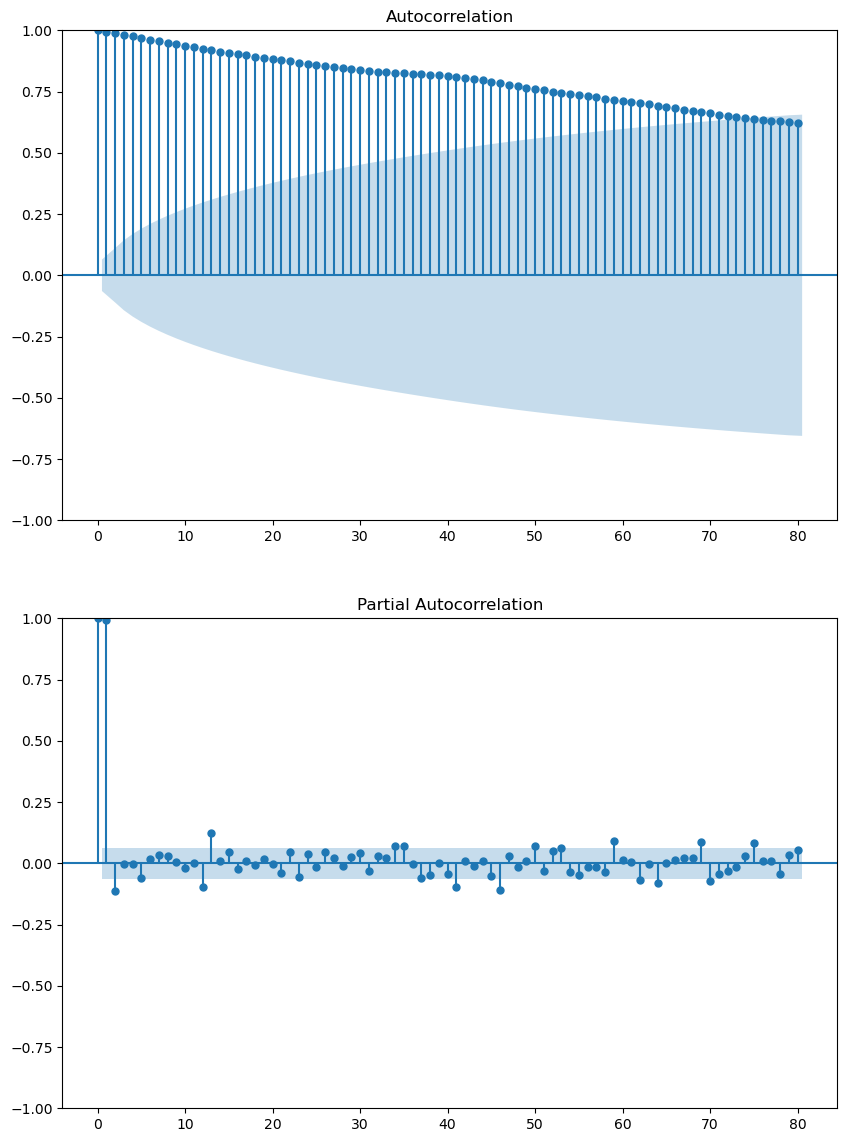

In [64]:
fig, axes = plt.subplots(2, 1, figsize = (10,14))
sm.graphics.tsa.plot_acf(df['Open'], lags = 80, ax= axes[0])  ## correlection of time series and time series which backward lag i 
sm.graphics.tsa.plot_pacf(df['Open'], lags = 80, ax= axes[1])  ## remove the inflence of the other time series between lags i 
plt.show()
# these graphs show that the correlation of time series with itself at lags of up to 80, within the interval of 74 days(approximately), prices is correlated closely

## resample data to frequent to 5 days 

In [65]:
df2 = df.asfreq('5d')

In [66]:
# resample data to 5 business days 
df1 = df.reset_index().resample(rule = '5d', on = 'Date')['Open'].mean()
df1

Date
2020-07-20    33.802000
2020-07-25    28.090000
2020-07-30    26.456667
2020-08-04    25.967500
2020-08-09    24.255000
                ...    
2024-03-11    13.188000
2024-03-16    11.870000
2024-03-21    11.218333
2024-03-26    10.496667
2024-03-31    11.585000
Freq: 5D, Name: Open, Length: 271, dtype: float64

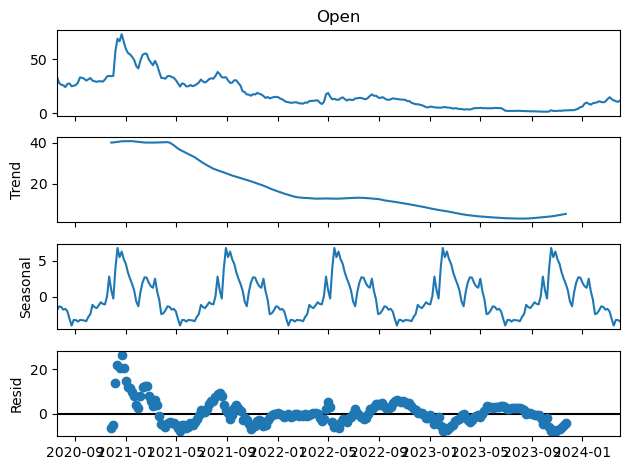

In [67]:
# check the seasonality and trend
res = seasonal_decompose(df1, model = 'additive', period = 52)
res.plot()
plt.show()

In [68]:
#  check the stationality 
ADF(df1, trend = 'c')
# the possiblity of not staitionality for this model is 47.1%
# the model is stationality

Test Statistic,-1.623
P-value,0.471
Lags,2


### Train the model

In [69]:
# use STLForecast to remove seasonality and then add it back 

mod = STLForecast(
  df1,
  sm.tsa.arima.ARIMA,
  model_kwargs = dict(order = (1, 0, 3), trend = 't')
)
res = mod.fit().model_result
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  271
Model:                 ARIMA(1, 0, 3)   Log Likelihood                -552.908
Date:                Tue, 02 Apr 2024   AIC                           1117.816
Time:                        23:05:50   BIC                           1139.429
Sample:                    07-20-2020   HQIC                          1126.494
                         - 03-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0303      0.197      0.153      0.878      -0.357       0.417
ar.L1          0.9912      0.008    130.201      0.000       0.976       1.006
ma.L1          0.4027      0.047      8.561      0.0

### Forecasting

In [70]:
steps = 6
forecast_df = res.get_forecast(steps = steps).summary_frame()
forecast_df

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-04-05,13.058167,1.843588,9.444800,16.671534
2024-04-10,13.122052,3.162669,6.923334,19.320769
2024-04-15,13.170208,4.131222,5.073162,21.267254
2024-04-20,13.157379,5.039937,3.279284,23.035474
2024-04-25,13.144931,5.795543,1.785875,24.503987
2024-04-30,13.132861,6.452259,0.486666,25.779056


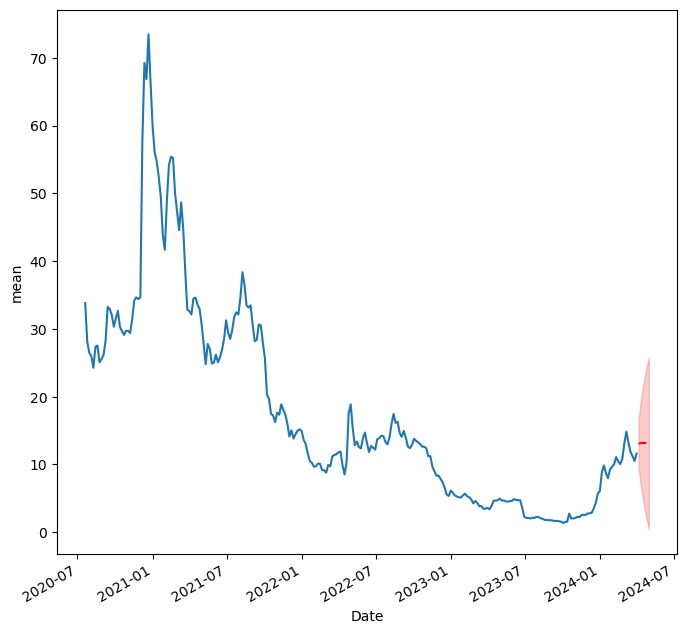

In [71]:
#draw the predict plot 
fig, axes = plt.subplots(figsize = (8, 8))
sns.lineplot(data = forecast_df, x = forecast_df.index, y = 'mean', linestyle = '--', c = 'red')
df1.plot(ax = axes)
axes.fill_between(x = forecast_df.index, y1 = forecast_df['mean_ci_lower'], y2 = forecast_df['mean_ci_upper'], color = 'r', alpha = 0.2)
plt.show()

### Exponential Smoothing Model

In [73]:
mod = sm.tsa.ExponentialSmoothing(endog = df1, trend = 'add')
res1 = mod.fit()

In [77]:
forecasts = pd.Series(res.forecast(steps = steps))
forecasts

2024-04-05    13.058167
2024-04-10    13.122052
2024-04-15    13.170208
2024-04-20    13.157379
2024-04-25    13.144931
2024-04-30    13.132861
Freq: 5D, Name: predicted_mean, dtype: float64